In [1]:
import numpy as np
import scipy as sc
import control.matlab as co
import control as cp
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from matplotlib.widgets import Slider
from matplotlib.animation import FuncAnimation
%matplotlib notebook

import warnings #Hide warnings regarding imaginary plots - NOT RECOMMENDED for normal use
warnings.filterwarnings('ignore')

# Aircraft Control using Youla-Kucera Parameterization

## Feedback control coupled with disturbance rejection

Abstract – The control of a simplified model of a vectored thrust aircraft is demonstrated in this report. The model is first controlled using a state feedback law and a PID controller tuned using Ziegler-Nichols Tuning. Additionally, Enhanced control using inverse based Youla-Kucera Parameterization is applied to the system to implement disturbance rejection. 

## 1 - Analysing the System Model

### 1.1 - Equations of Motion

The dynamic model of the aircraft is shown in the figure below. 
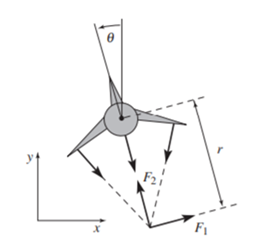

<div align="center"> Fig. 1 Dynamic model of the aircraft </div>


| Notation	| Parameter	| Units |
| :--- | :---- | :----   |
| M	   | Mass of the Aircraft	| Kg         |
| J	   | Moment of Inertia	    | kg/m-$s^2$ |
| r    | Thrust offset	        | m          |
| g    |Acceleration due to gravity	|$m/s^2$|
| c    |Damping Constant	|N-s/m|
|x 	|Aircraft Horizontal Position	|M|
|y 	|Aircraft Vertical Position	|M|
|$\theta$	|Aircraft Roll Angle	|Degrees|

Let 𝑥, 𝑦 and $\theta$ denote the position and orientation of the centre of mass of the aircraft. Table 1 shows the parameters used for the model. Let M = 10 Kg, J = 10 Kg-$m^2$ , r = 1m, g = 9.81 m/$s^2$ and c = 1 N-s/m. From Newton’s law, the equations for horizontal motion, vertical motion, and roll motion, respectively, are

$$ M\ddot{x} = F_1 cos\theta - F_2 sin\theta - c\dot{x} \;\;\;\;\;\;\;\;\;\;\;\;\;\;  [1]                             $$

$$ M\ddot{y} = F_1 sin\theta + F_2 cos\theta - Mg - c\dot{y} \;\;\;\;\;  [2]                      $$

$$ J\ddot{\theta} = rF_1 \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \;\;\;\;\; [3]$$

### 1.2 - System Linearization

The equations [1] - [3] are not linear. We now proceed to linearize the system around the equilibrium point for small perturbations. Let the state of the system be defined as

$$ G = \left[ \matrix{x,y,\theta,\dot{x},\dot{y},\dot{\theta}} \right]^T \;\;\;\;\;\;\;\;\;\;  [4]$$

From the equations above (See the above linked paper for full derivation, 

$$ \dot{G} = f(t) \;\;\;\;\;\;\;\;\;\; [5]$$

The above system is in equilibrium when $\theta = 0^0$. This implies that $\ddot{\theta} = \dot{\theta} = 0$. After substituting $\ddot{\theta} = 0$ in eq. [3], we have $F_1 = 0 $ and $F_2 = Mg$.

We linearize the non-linear model using **Jacobian Linearization** where 

$$ A := \left[ \frac{\delta f}{\delta G} \right]_{equi}  $$
$$ B := \left[ \frac{\delta f}{\delta u} \right]_{equi}  $$

Using this formula, we get the statespace model of the system shown below:

$$ A = \left[ \matrix{0 & 0 & 0 & 1 & 0 & 0 \\
                      0 & 0 & 0 & 0 & 1 & 0 \\
                      0 & 0 & 0 & 0 & 0 & 1 \\
                      0 & 0 & -g & \frac{-c}{M} & 0 & 0 \\
                      0 & 0 & 0 & 0 & \frac{-c}{M} & 0 \\
                      0 & 0 & 0 & 0 & 0 & 0} \right]$$

$$ B = \left[ \matrix{0 & 0 \\
                      0 & 0 \\
                      0 & 0 \\
                      1/M & 0 \\
                      0 & 1/M \\
                      0 & 0} \right] \;\;\;\;\;\;\;\;\;\;\;  [6] $$
                      
The output to be tracked is the horizontal and the vertical position of the aircraft without any initial feedforward input. Therefore, the matrices C and D are

$$ C = \left[ \matrix{1 & 0 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 & 0} \right] $$

$$ D = \left[ \matrix{0 & 0 \\ 0 & 0}\right]  \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; [7]$$

*The Code cell below is a function to create the statespace model of the system from given parameters*

In [2]:
#Creating the system model

def linear_system(g,c,m,r,J):
    """ Creates the state space matrices of the system model as defined in the referred paper.
    
            Inputs: 
                    g = gravity
                    c = damping constant
                    m = mass
                    r = perpendicular distance from thrust to point of action
                    J = inertia
            
            Returns:
                    A, B, C, D = System state space matrices
    """
    
    A = np.array([[0,0,0,1,0,0],
                  [0,0,0,0,1,0],
                  [0,0,0,0,0,1],
                  [0,0,-g,-c/m,0,0],
                  [0,0,0,0,-c/m,0],
                  [0,0,0,0,0,0]])
    
    B = np.array([[0,0],[0,0],[0,0],[1/m,0],[0,1/m],[r/J,0]])
    C = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0]])
    D = np.array([[0,0],[0,0]])
    
    return A,B,C,D


### 2 - Initial Feedback Control of the System

The system is initially controlled using Full State Feedback Control. The function below creates a closed-loop system from an input system model. 

In [3]:
def lqr(A,B,C,D):
    
    """ Creates a state feedback controller to control the linearized system as defined in the function 'linear_system()'.
    
        Inputs:
                A, B, C, D = State space matrices
                
        Returns:
                syscl = Closed-loop controlled system
                Kfb = State feedback gain matrix
                
    """
    
    Q = np.identity(6)
    R = np.array([[0.001,0],[0,0.001]])
    
    [Kfb,S,E] = co.lqr(A,B,Q,R)
    
    syscl = co.ss(A-B*Kfb,B,C,D)
    
    return syscl,Kfb
    

The code cell below creates a closed-loop model of the system using the functions defined above

In [4]:
# Main

# Defining Parameters Below
c = 1
M = 10
r = 1
J = 10
g = 9.81

# Creating Linearized System model
A,B,C,D = linear_system(g,c,M,r,J)
sys_ct = co.ss(A,B,C,D)

# Stabilizing with lqr
syscl,Kfb = lqr(A,B,C,D)

### 3 - Youla-Kucera Parameterization 

Reference: See section *3. Control Problem* of the paper [linked]() above. 

The code below is to design and create the Youla-Kucera Parameterization similar to the paper. Relevant Comments are provided for understanding and explaining flow of code. 

#### 3.1 - Plant Creation

In [5]:
# The system is decoupled into separate systems for x and y direction.
# The parameterization is applied ONLY for the x-direction.

# Extracting x transfer function
sys_x = cp.tf(syscl[0,0])

Ts = 0.1 # Sampling period

# Zeros of Plant
zero_p = np.array([-0.7293,1.3680,0.8993,0.7423, 0.7311]) 

# Poles of plant
pole_p = np.array([0.7478 +0.123j,0.7478 -0.123j, 0.8993,0.9048,0.7423, 0.7413])

# The above are the same as sys_x, but for some reason, python does pole-zero cancellation.
# To avoid that, system is created by extracting the polesa nd zeros.

# Creating the Plant
P = co.tf(np.poly(zero_p),np.poly(pole_p),Ts) #Notice that the sampling period is given for a DT system
P = P/co.dcgain(P) # This is done so that the dcgain is 1

<IPython.core.display.Javascript object>


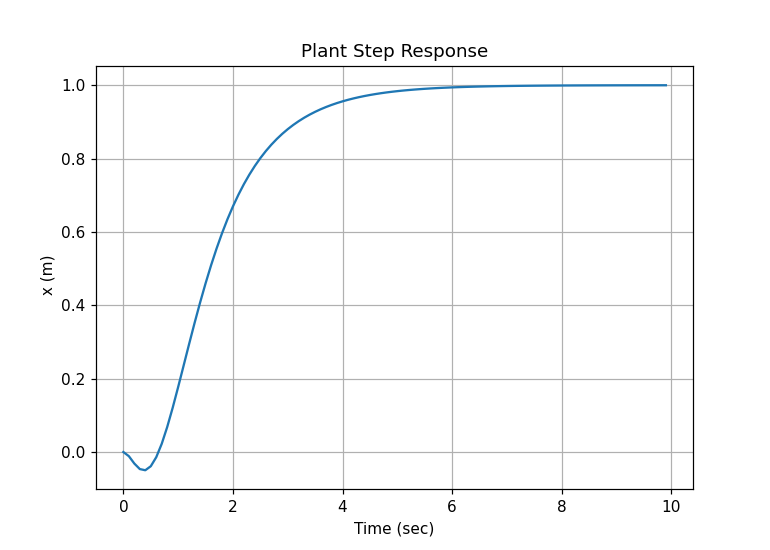

Text(0.5, 1.0, 'Plant Step Response')

In [26]:
# Lets plot the Step response of the plant. 
T = np.arange(0,10,0.1)
T,x = co.step(P,T)

fig1 = plt.figure(1,figsize = [7,5])
plt.grid()
plt.plot(x,T)
plt.xlabel("Time (sec)")
plt.ylabel(" x (m)")
plt.title("Plant Step Response")

Notice the initial undershoot because of the non-minimum phase zero.

#### 3.2 - Baseline Controller C

In [7]:
# Baseline Controller
C = co.tf(np.array([0]),np.array([0, 1]),Ts)

m=1 #Relative Order of the system

w0 = 0  # Frequency of Disturbance     
gamma = 0.96 

# Creating z so it can be used algebraically in other equations. This is similar to z = tf('z') in MATLAB
z = co.tf(np.array([1,0]),np.array([0,1]),Ts) 

# Q for constant or low frequency disturbance
Q = ((2-2*gamma)*np.cos(w0) + (gamma**2 - 1)*z**-1)/(1-2*gamma*np.cos(w0)*(z**-1) + gamma**2 *z**-2)

# A for m = 1
A = 1 - z**-m*Q

#### 3.3 - Plant Inverse and All stabilizing Controller Call

Plant inverse is designed using approximate inverse methods for non-minimum phase systems. The magnitude is constant.

In [8]:
# Designing Plant Inverse

#Zeros picked for approximate Inverse
zeros = np.array([1/1.368, -0.7293, 0.8993, 0.7423, 0.7311]) #Zeros picked for approximate Inverse

# Poles
poles = co.pole(P)

# Creating inverse P_hat
P_hat_1 = co.tf(np.poly(zeros),np.poly(poles),Ts);
P_hat_2 = P_hat_1*co.dcgain(P)/co.dcgain(P_hat_1);
P_hat = z**(-m) * (P_hat_2**(-1));


# The all stabilizing controller
Call = ((z**-m)*P_hat*Q)/(1 - z**(-m)*Q)

### 4 - System Interconnections

The next step is to connect all the systems together and simulate.

<IPython.core.display.Javascript object>


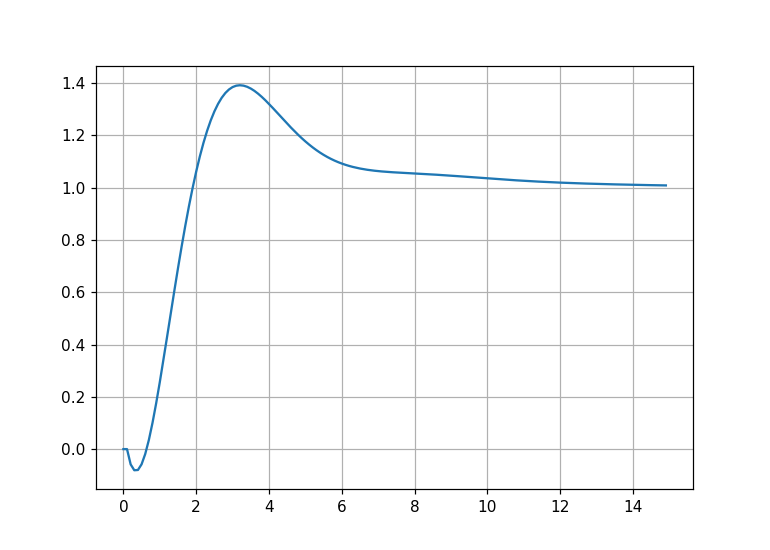

In [13]:
dist = z/z
appended = co.append(co.ss(P),co.ss(Call),dist)
inputs = np.array([[2],[3]])
outputs = np.array([1])

connections = np.array([[2,-1,0],[1,2,3]])

sys_final = co.connect(appended,connections,inputs,outputs) 

t_x = np.arange(0,15,0.1)
x,t_x = co.step(sys_final[:,0],t_x)

fig3 = plt.figure(3,figsize = [7,5])
plt.plot(t_x,x)
plt.grid()

<IPython.core.display.Javascript object>


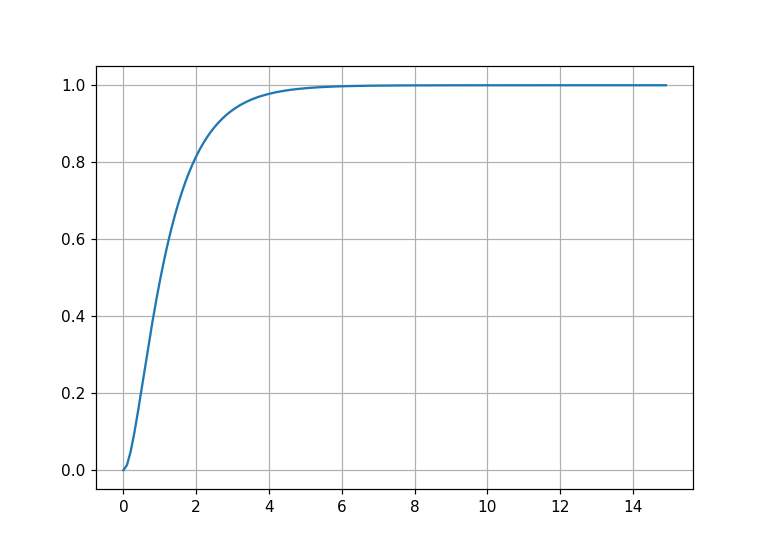

In [14]:
sys_y = co.tf(syscl[1,1])
sys_y = sys_y/0.031622

t_y = np.arange(0,15,0.1)
y,t_y = co.step(sys_y,t_y)

fig3 = plt.figure(4,figsize = [7,5])
plt.plot(t_y,y)
plt.grid()

In [15]:
def animate(i):
    """
    This function takes in the value from Sliders and updates the graph animation. The way this animation function works is
    similar to drawnow in matlab. It continuously plots the data and makes it look like an animation. 
    
    The code below uses the updated y vector that will be imported from the main body or update() function and sets the
    initial position of the cart, wheels and pendulum. We need to plot them separately and make it look like a pendulum
    on a cart.    
    """
    # Update the tuples that carry plot data
    tail.set_data([x[i],x[i]] , [y[i],y[i]+0.5])     # Update the Cart Postion Data
    wing1.set_data([x[i],x[i]+0.5] , [y[i],y[i]-0.25])                  # Update the wheel 1 Postion Data
    wing2.set_data([ x[i],x[i]-0.5] , [y[i],y[i]-0.25])                  # Update the Wheel 2 Postion Data
    
    body.set_data(x[i],y[i])
    
    time_text.set_text(time_template % (i*0.1)) # Update the time text data

In [16]:
def update_button(i):
    ani.event_source.start(1)

<IPython.core.display.Javascript object>


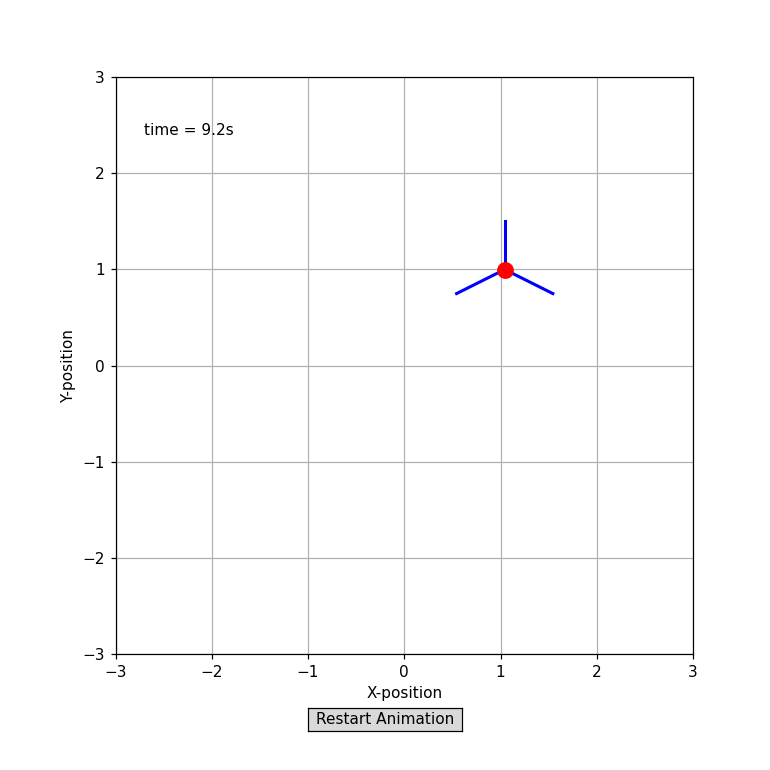

In [18]:
fig5 = plt.figure(5,figsize=(7,7))
ax = fig5.add_subplot(111, aspect='equal', autoscale_on=False, position=[.15,.15,.75,.75] ) #Adds subplot to the figure
ax.grid()

ax.set_xlim([-3,3])
ax.set_ylim([-3,3])
plt.xlabel("X-position")
plt.ylabel("Y-position")

#button
ax_button = plt.axes([0.4, 0.05, 0.2, 0.03 ])
button = Button(ax_button,'Restart Animation')
button.on_clicked(update_button)  #CONNECTING THE BUTTON TO THE UPDATE FUNCTION


tail, = ax.plot([0,0],[0,0.5],'b',linewidth=2)
wing1, = ax.plot([0,0.5],[0,-0.25],'b',linewidth=2)
wing2, = ax.plot([0,-0.5],[0,-0.25],'b',linewidth=2)
body, = ax.plot(0,0,'or',ms = 10)

time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

ani = FuncAnimation(fig5, animate,frames = len(t_x), interval=20, repeat = True)

### Disturbance in x-direction (wind)

<IPython.core.display.Javascript object>


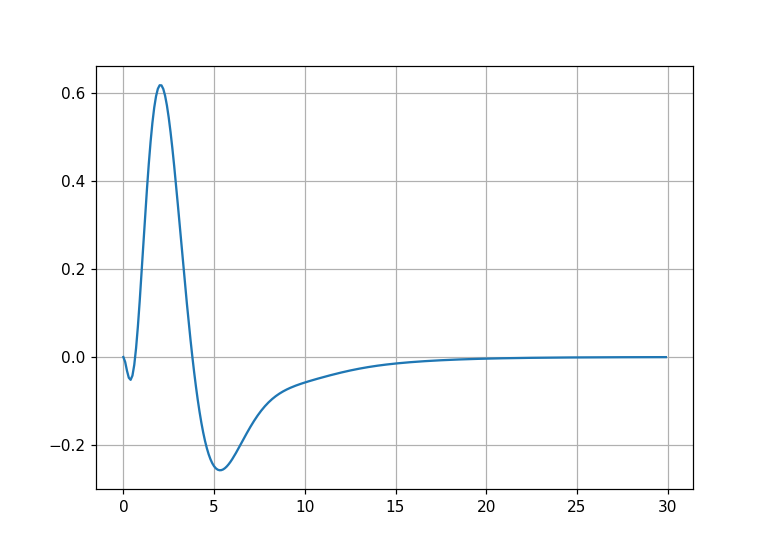

In [19]:
t_dist_x = np.arange(0,30,0.1)
x_dist,t_dist_x = co.step(sys_final[:,1],t_dist_x)

fig6 = plt.figure(6,figsize = [7,5])
plt.plot(t_dist_x,x_dist)
plt.grid()

In [20]:
def animate_dist(i):
    """
    This function takes in the value from Sliders and updates the graph animation. The way this animation function works is
    similar to drawnow in matlab. It continuously plots the data and makes it look like an animation. 
    
    The code below uses the updated y vector that will be imported from the main body or update() function and sets the
    initial position of the cart, wheels and pendulum. We need to plot them separately and make it look like a pendulum
    on a cart.    
    """
    # Update the tuples that carry plot data
    tail.set_data([x_dist[i],x_dist[i]] , [0,0.5])     # Update the Cart Postion Data
    wing1.set_data([x_dist[i],x_dist[i]+0.5] , [0,-0.25])                  # Update the wheel 1 Postion Data
    wing2.set_data([ x_dist[i],x_dist[i]-0.5] , [0,-0.25])                  # Update the Wheel 2 Postion Data
    
    body.set_data(x_dist[i],0)
    
    time_text.set_text(time_template % (i*0.1)) # Update the time text data
    
   
    
    

In [21]:
def animate_wind(k):
    
    
    wind_speed = 0.5
    
    wind_arrow1.set_data([-2+wind_speed*wind[k],-1+wind_speed*wind[k]],[2,2])
    wind_arrow2.set_data([-2+wind_speed*wind[k],-1+wind_speed*wind[k]],[0,0])
    wind_arrow3.set_data([-2+wind_speed*wind[k],-1+wind_speed*wind[k]],[-2,-2])
    
    wind_arrow4.set_data([-2+wind_speed*wind[k],-1+wind_speed*wind[k]],[1,1])
    wind_arrow5.set_data([-2+wind_speed*wind[k],-1+wind_speed*wind[k]],[-1,-1])
    wind_arrow6.set_data([-2+wind_speed*wind[k],-1+wind_speed*wind[k]],[-3,-3])
    

In [24]:
fig7 = plt.figure(7,figsize=(7,7))
ax2 = fig7.add_subplot(111, aspect='equal', autoscale_on=False, position=[.15,.15,.75,.75] ) #Adds subplot to the figure
ax2.grid()

ax2.set_xlim([-3,3])
ax2.set_ylim([-3,3])
plt.xlabel("X-position")
plt.ylabel("Y-position")

#button
#ax_button = plt.axes([0.4, 0.05, 0.2, 0.03 ])
#button = Button(ax_button,'Restart Animation')
#button.on_clicked(update_button)  #CONNECTING THE BUTTON TO THE UPDATE FUNCTION


tail, = ax2.plot([0,0],[0,0.5],'b',linewidth=2)
wing1, = ax2.plot([0,0.5],[0,-0.25],'b',linewidth=2)
wing2, = ax2.plot([0,-0.5],[0,-0.25],'b',linewidth=2)
body, = ax2.plot(0,0,'or',ms = 10)

time_template = 'time = %.1fs'
time_text = ax2.text(0.05, 0.9, '', transform=ax.transAxes)

wind_arrow1, = ax2.plot([-2,-1],[2,2],'--k', linewidth = 2)
wind_arrow2, = ax2.plot([-2,-1],[0,0],'--k', linewidth = 2)
wind_arrow3, = ax2.plot([-2,-1],[-2,-2],'--k', linewidth = 2)

wind_arrow4, = ax2.plot([-2,-1],[1,1],'--k', linewidth = 2)
wind_arrow5, = ax2.plot([-2,-1],[-1,-1],'--k', linewidth = 2)
wind_arrow6, = ax2.plot([-2,-1],[-3,-3],'--k', linewidth = 2)

wind_text = 'Wind moving to the right'
wind_temp = ax2.text(0.05,0.1,wind_text,transform=ax.transAxes)

wind1 = np.arange(0,10,0.1)
wind = np.append(wind1,np.append(wind1,wind1))
ani2 = FuncAnimation(fig7, animate_dist,frames = len(t_dist_x), interval=20, repeat = True)
ani3 = FuncAnimation(fig7, animate_wind,frames = len(t_dist_x), interval=20, repeat = True)

<IPython.core.display.Javascript object>